In [62]:
import os
import sys
import pickle
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

In [2]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


In [3]:
subject_id = nsrr.all_ids[0]

In [4]:
subject_id

'ccshs-trec-1800001'

In [5]:
signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)

In [6]:
signal.size

2802000

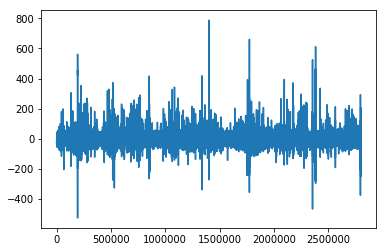

In [7]:
plt.plot(signal)
plt.show()

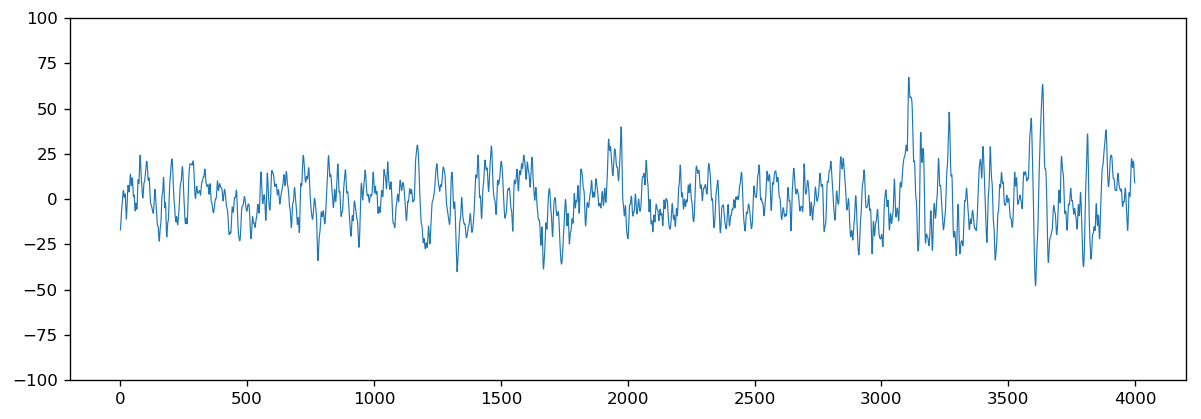

In [10]:
plt.figure(figsize=(12, 4), dpi=120)
plt.plot(signal[100000:104000], linewidth=0.7)
plt.ylim([-100, 100])
plt.show()

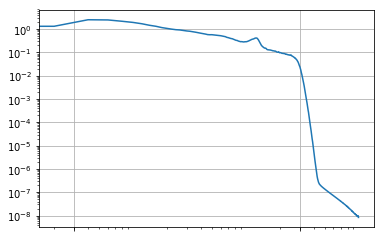

In [19]:
fs = nsrr.fs
f, y = utils.power_spectrum_by_sliding_window(signal, fs)

plt.plot(f, y)
plt.yscale('log')
plt.xscale('log')
plt.xticks([0.3, 30])
plt.grid()
plt.show()

In [20]:
original_fname = os.path.join(nsrr.dataset_dir, 'ccshs', 'register_and_state', '%s.npz' % subject_id)
original_data = np.load(original_fname)
original_signal = original_data['signal']

In [21]:
original_signal.shape

(2802000,)

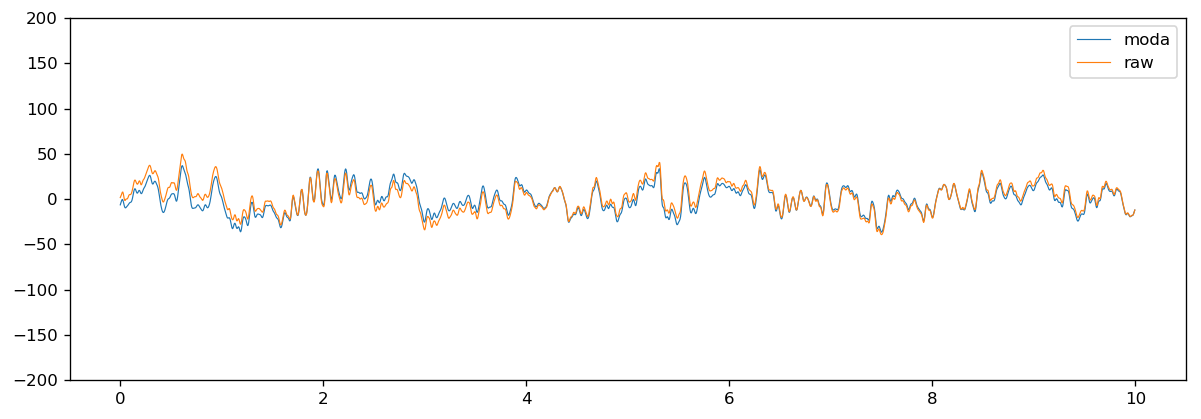

In [27]:
start_sample = 320000
window_size = 2000


time_axis = np.arange(window_size) / fs
plt.figure(figsize=(12, 4), dpi=120)
plt.plot(time_axis, signal[start_sample:start_sample + window_size], linewidth=0.7, label="moda")
plt.plot(time_axis, original_signal[start_sample:start_sample + window_size], linewidth=0.7, label="raw")
plt.ylim([-200, 200])
plt.legend()
plt.show()

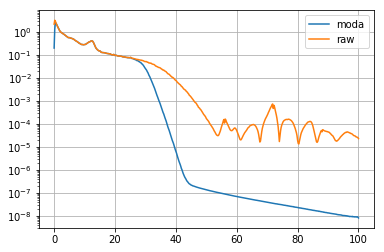

In [31]:
fs = nsrr.fs
f, y = utils.power_spectrum_by_sliding_window(signal, fs)
f, y_original = utils.power_spectrum_by_sliding_window(original_signal, fs)

plt.plot(f, y, label="moda")
plt.plot(f, y_original, label="raw")
plt.yscale('log')
#plt.xscale('log')
plt.legend()
#plt.xticks([0.3, 30])
plt.grid()
plt.show()

In [33]:
subject_data = nsrr.read_subject_data(subject_id)

In [37]:
subject_data['sex']

array('f', dtype='<U1')

# Check ensemble

In [7]:
pred_path = os.path.join('../results/predictions_nsrr_ss/20210715_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_desc_check_to_e1_n2_train_nsrr_ss/v2_time/fold0/prediction_n2_test.pkl')
pred_path

'../results/predictions_nsrr_ss/20210715_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_desc_check_to_e1_n2_train_nsrr_ss/v2_time/fold0/prediction_n2_test.pkl'

In [10]:
with open(pred_path, 'rb') as handle:
    pred_dict = pickle.load(handle)

In [12]:
subject_ids = np.sort(list(pred_dict.keys()))

In [13]:
len(subject_ids)

100

In [32]:
subject_id = subject_ids[0]

# Get subject's data
print("Subject", subject_id)
fs = nsrr.fs
page_duration = nsrr.original_page_duration
subject_data = nsrr.read_subject_data(subject_id)
signal = subject_data['signal']
hypnogram = subject_data['hypnogram']
proba = pred_dict[subject_id]
proba_up = np.repeat(proba, 8)
age = subject_data['age']
sex = subject_data['sex']
n2_pages = np.where(hypnogram == nsrr.n2_id)[0]
print(signal.size, proba.size, proba_up.size, hypnogram.size, n2_pages.size, age, sex)

Subject ccshs-trec-1800253
3324000 415500 3324000 554 499 17.7 m


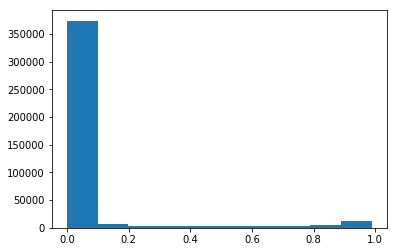

In [33]:
plt.hist(proba)
plt.show()

In [34]:
# postprocessing
post_params = {
    pkeys.PAGE_DURATION: page_duration,
    pkeys.SS_MIN_SEPARATION: 0.3,
    pkeys.SS_MIN_DURATION: 0.3,
    pkeys.SS_MAX_DURATION: None,
}
poster = PostProcessor(constants.SPINDLE, params=post_params)
# poster.params

In [35]:
marks = poster.proba2stamps(proba, thr=0.5, pages_indices_subset=n2_pages)
marks.shape

(1178, 2)

In [36]:
density = marks.shape[0] / (n2_pages.size * page_duration / 60)
density

4.721442885771543

In [ ]:
# TODO:
# - Check some portions of signal

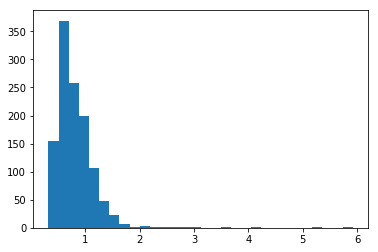

In [39]:
durations = (marks[:, 1] - marks[:, 0] + 1) / fs

plt.hist(durations, bins=30)
plt.show()

In [43]:
largest_marks_locs = np.argsort(-durations)

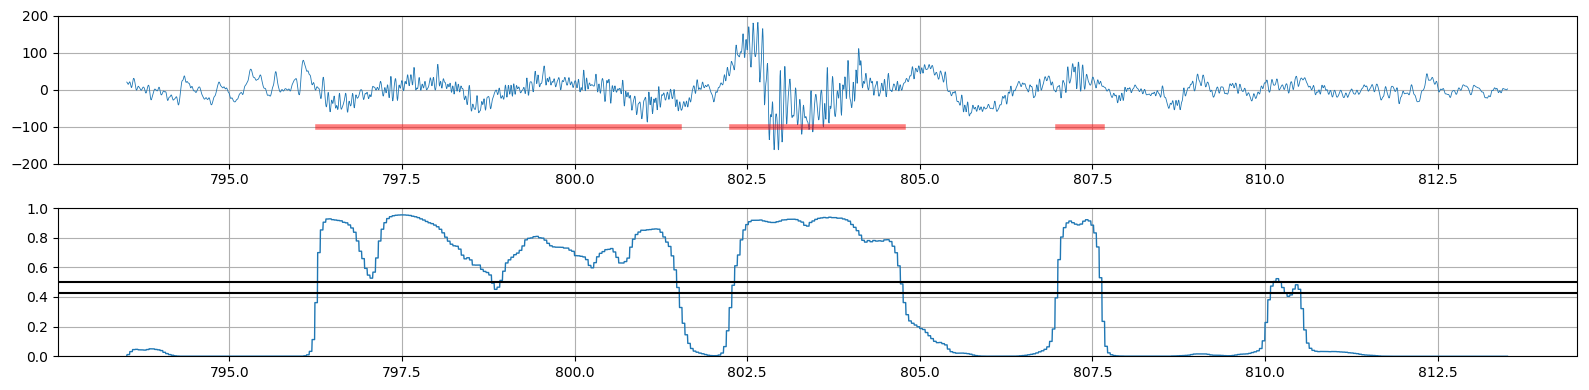

In [59]:
which_mark = largest_marks_locs[7]
window_duration = 20

# Show mark
window_size = int(window_duration * fs)
mark = marks[which_mark]
center_sample = int(mark.mean())
start_sample = center_sample - window_size // 2
end_sample = start_sample + window_size

segment_marks = utils.filter_stamps(marks, start_sample, end_sample)

time_axis = np.arange(start_sample, end_sample) / fs
fig, axes = plt.subplots(2, 1, figsize=(16, 4), dpi=100)

axes[0].plot(time_axis, signal[start_sample:end_sample], linewidth=0.6)
axes[0].set_ylim([-200, 200])
axes[0].grid()
for m in segment_marks:
    m = np.clip(m, a_min=start_sample, a_max=end_sample)
    axes[0].plot(m/fs, [-100, -100], linewidth=4, color="r", alpha=0.5)

axes[1].plot(time_axis, proba_up[start_sample:end_sample], linewidth=1)
axes[1].axhline(0.5, color="k")
axes[1].axhline(0.5 * 0.85, color="k")
axes[1].set_ylim([0, 1])
axes[1].grid()

plt.tight_layout()
plt.show()

In [81]:
# - Check histograms of duration, density and amplitude for the sample of 100 subjects to see if it makes sense
# Los histogramas de parametros, sobre todo de densidad, igual son sensibles a los criterios de duracion que establezca.
# Aumentar la duracion minima a 0.5 y separacion 0.5 por ej disminuye el numero de eventos.

fs = nsrr.fs
page_duration = nsrr.original_page_duration
post_params = {
    pkeys.PAGE_DURATION: page_duration,
    pkeys.SS_MIN_SEPARATION: 0.5,
    pkeys.SS_MIN_DURATION: 0.5,
    pkeys.SS_MAX_DURATION: 3.0,
}
poster = PostProcessor(constants.SPINDLE, params=post_params)

table = {
    'age': [],
    'sex': [],
    'density': [],
    'mean_duration': [],
    'mean_amplitude': [],
    'mean_proba_event': [],
    'mean_frequency': [],
}

for subject_id in subject_ids:
    subject_data = nsrr.read_subject_data(subject_id)
    signal = subject_data['signal']
    hypnogram = subject_data['hypnogram']
    proba = pred_dict[subject_id]
    proba_up = np.repeat(proba, 8)
    age = subject_data['age']
    sex = subject_data['sex']
    n2_pages = np.where(hypnogram == nsrr.n2_id)[0]
    marks = poster.proba2stamps(proba, thr=0.5, pages_indices_subset=n2_pages)
    
    marks_proba = det_utils.get_event_probabilities(marks, proba)
    # Compute params
    density = marks.shape[0] / (n2_pages.size * page_duration / 60)
    durations = (marks[:, 1] - marks[:, 0] + 1) / fs
    signal_filt = fig_utils.get_filtered_signal_for_event(signal, fs, constants.SPINDLE)
    marks_signal = [signal_filt[m[0]:m[1]+1] for m in marks]
    amplitudes = np.array([fig_utils.get_amplitude_spindle(x, fs) for x in marks_signal])
    frequencies = np.array([fig_utils.get_frequency_by_fft(x, fs) for x in marks_signal])
    
    table['age'].append(age.item())
    table['sex'].append(sex.item())
    table['density'].append(density)
    table['mean_duration'].append(durations.mean())
    table['mean_amplitude'].append(amplitudes.mean())
    table['mean_frequency'].append(frequencies.mean())
    table['mean_proba_event'].append(marks_proba.astype(np.float32).mean())
table = pd.DataFrame.from_dict(table)
table.head()

,age,sex,density,mean_duration,mean_amplitude,mean_proba_event,mean_frequency
0,17.70000,m,4.060120,0.860967,37.101318,0.900421,13.177591
1,18.80000,f,6.401691,1.046605,55.162535,0.906610,13.344584
2,17.83000,m,1.457557,0.883523,31.366838,0.864935,12.886932
3,18.21000,f,6.191571,1.096535,53.832754,0.917682,13.243007
4,17.83436,m,4.461224,0.869826,39.462018,0.909082,13.314639


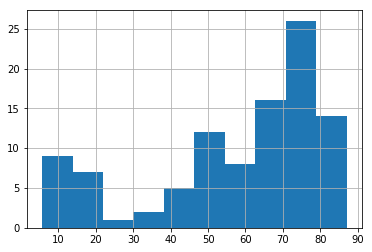

In [82]:
table['age'].hist()

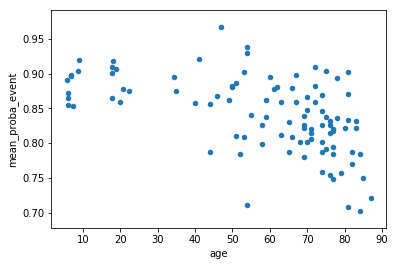

In [90]:
table.plot.scatter(x='age', y='mean_proba_event')